In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from utils.networks import build_resnet18


import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

from IPython.display import clear_output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset:

In [2]:
class Config:
    def __init__(
        self,
        dataset='cifar100',
        data_folder='dataset',
        batch_size=256,
        num_workers=8,
        size=32
    ):
        self.dataset = dataset
        self.data_folder = data_folder
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.size = size

opt = Config(
    dataset='cifar100',
    data_folder='dataset',
    batch_size=256,
    num_workers=8,
    size=32
)

In [3]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

def set_loader_contrastive(opt):
    # construct data loader
    if opt.dataset == 'cifar10':
        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2023, 0.1994, 0.2010)
    elif opt.dataset == 'cifar100':
        mean = (0.5071, 0.4867, 0.4408)
        std = (0.2675, 0.2565, 0.2761)
    elif opt.dataset == 'path':
        mean = eval(opt.mean)
        std = eval(opt.std)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))
    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=opt.size, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    if opt.dataset == 'cifar10':
        train_dataset = datasets.CIFAR10(root=opt.data_folder,
                                         transform=TwoCropTransform(train_transform),
                                         download=True)
    elif opt.dataset == 'cifar100':
        train_dataset = datasets.CIFAR100(root=opt.data_folder,
                                          transform=TwoCropTransform(train_transform),
                                          download=True)
    elif opt.dataset == 'path':
        train_dataset = datasets.ImageFolder(root=opt.data_folder,
                                            transform=TwoCropTransform(train_transform))
    else:
        raise ValueError(opt.dataset)

    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
        num_workers=opt.num_workers, pin_memory=True, sampler=train_sampler)

    return train_loader


# opt = Config(
#     dataset='cifar10',
#     data_folder='dataset',
#     batch_size=16,
#     num_workers=4
# )

# train_loader = set_loader_contrastive(opt)

# (x1, x2), y = next(iter(train_loader))

---
# Crtierion:

In [4]:
class InfoNCELoss(nn.Module):
    def __init__(self):
        super(InfoNCELoss, self).__init__()
        self.CE = nn.CrossEntropyLoss()


    def forward(self, z1, z2, batch_size, temperature):
        features = torch.cat((z1, z2), dim=0)

        labels = torch.cat([torch.arange(batch_size) for i in range(2)], dim=0).to(device)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

        features = F.normalize(features, dim=1)

        full_similarity_matrix = torch.matmul(features, features.T)

        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = full_similarity_matrix[~mask].view(full_similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

        logits = logits / temperature
        loss = self.CE(logits, labels)

        return full_similarity_matrix, logits, loss
    
# criterion = InfoNCELoss()

---
# Training:

In [5]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [14]:
opt = Config(
    dataset='cifar10',
    data_folder='dataset',
    batch_size=512,
    num_workers=4
)

train_loader = set_loader_contrastive(opt)

Files already downloaded and verified


In [19]:
model = build_resnet18().to(device)

criterion = InfoNCELoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-6,
    nesterov=True)


def get_lr(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(step / total_steps * np.pi))

scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        100 * len(train_loader),
        0.6,  # lr_lambda computes multiplicative factor
        1e-3
    )
)

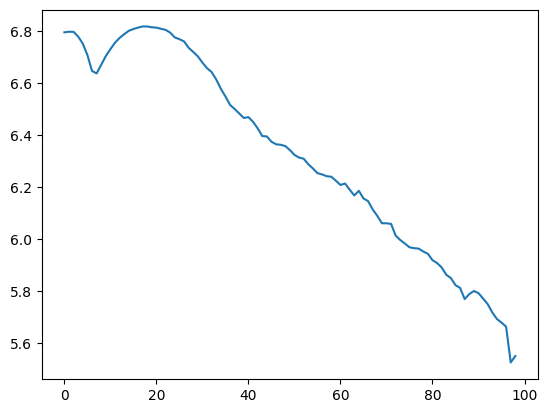

Epoch: 2 | Loss: 3.9994:   1%|          | 1/100 [03:12<5:17:28, 192.41s/it]


KeyboardInterrupt: 

In [20]:
EPOCHS = 100
PLOT_EACH = 100

losses = []

tqdm_range_epochs = tqdm(range(EPOCHS))
for epoch in tqdm_range_epochs:
    tqdm_train_loader = enumerate(train_loader)
    for i, ((x1, x2), y) in tqdm_train_loader:

        x1 = x1.to(device)
        x2 = x2.to(device)

        _, z1 = model(x1)
        _, z2 = model(x2)
        
        # print(x1.min(), z1.min())

        _, _, loss = criterion(z1, z2, batch_size=x1.shape[0], temperature=0.07)

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        scheduler.step()

        losses.append( loss.item() )

        tqdm_range_epochs.set_description(f'Epoch: {epoch+1} | Loss: {loss.item():.4f}')


        del x1, x2, loss, _
        torch.cuda.empty_cache()

        if i % PLOT_EACH == 0:
            clear_output(True)
            plt.plot(smooth_curve(losses))
            plt.show()


        # print('-'*20)


In [13]:
z1.max()

tensor(19.4533, device='cuda:0', grad_fn=<MaxBackward1>)

In [11]:
z1.shape

torch.Size([64, 512])

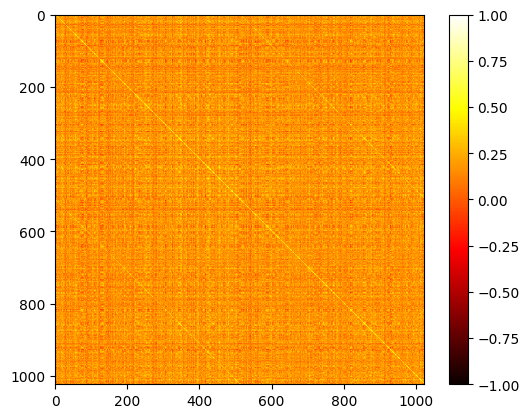

In [21]:
sim, _, _ = criterion(z1, z2, batch_size=z1.shape[0], temperature=0.07)
img = plt.imshow(sim.cpu().detach(), vmin=-1, vmax=1, cmap='hot')
cbar = plt.colorbar(img, orientation='vertical')
plt.show()

In [14]:
torch.save(model.state_dict(), 'params/contrastive_resnet18.pt')